# Mood-RL Behavioral Analysis

**Note:** The figures below were generated from only a subset of the original data presented in the manuscript. The findings below should not be extrapolated to those presented in [Eldar & Niv (2015)](https://www.nature.com/articles/ncomms7149).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pandas import DataFrame, concat, read_csv
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
data = read_csv('data/moodRL_data.csv')
metadata = read_csv('data/moodRL_metadata.csv')
ratings = read_csv('data/moodRL_ratings.csv')

## Section 1: Task Performance
In this first section, we quantify the participants' performance on the slot machines task. Performance is quantified by the fraction of optimal decisions made, where optimality is defined by choosing the slot machine with objectively higher reward probability.

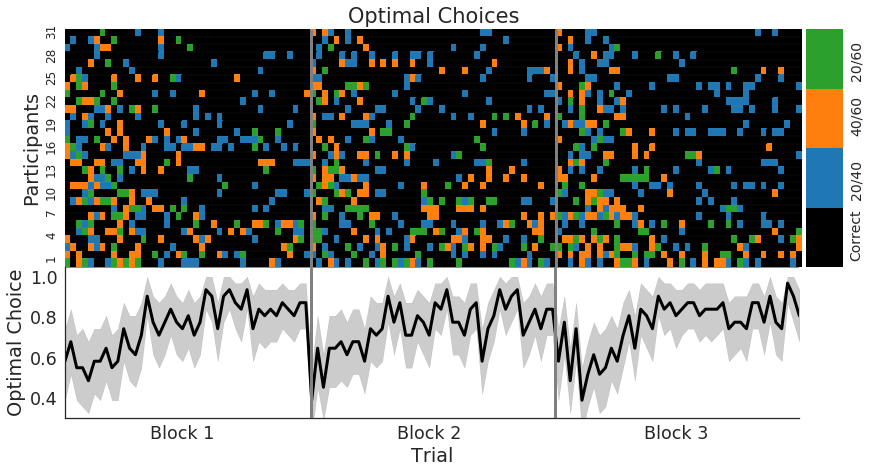

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Subset data to learning blocks.
optimal_choice = data[data.Block<4].copy()

## Re-code machines to range [1-3].
optimal_choice[['M1','M2','Choice']] = np.where(optimal_choice[['M1','M2','Choice']] % 3, 
                                                optimal_choice[['M1','M2','Choice']] % 3, 3)

## Re-code trials.
optimal_choice['Trial'] += (optimal_choice['Block'] - 1) * optimal_choice['Trial'].max()

## Find trials where optimal choice is made. 
optimal_choice['Optimal'] = np.equal(optimal_choice['Choice'], 
                                     optimal_choice[['M1','M2']].max(axis=1))

## Classify errors.
optimal_choice['Error'] = np.where(optimal_choice['Optimal'],
                                   optimal_choice['Optimal'],
                                   optimal_choice[['M1','M2']].sum(axis=1)-1)

## Reverse code errors 3 (M1 > M3) and 4 (M2 > M3).
optimal_choice['Error'] = np.where(optimal_choice.Error==3, 4, 
                                   np.where(optimal_choice.Error==4, 3, 
                                            optimal_choice.Error))

## Organize error data.
n_subjects = optimal_choice.Datetime.unique().size
n_trials = optimal_choice.Trial.max()
errors = optimal_choice.Error.values.reshape(n_subjects, n_trials).astype(int)

## Sort by weighted sum of errors.
sort_ix = np.argsort(errors.sum(axis=-1))
errors = errors[sort_ix]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize figure.
fig = plt.figure(figsize=(12,6))

## Initialize canvas and divider.
gs = gridspec.GridSpec(1,1)
gs.update(left=0.05, right=0.95, bottom=0.4, top=0.95, hspace=0, wspace=0)
ax = plt.subplot(gs[0, 0])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

## Plot.
cmap = ListedColormap(np.insert( sns.color_palette(n_colors=3).as_hex(), 0, 'k' ) )
sns.heatmap(errors, cmap=cmap, cbar=True, ax=ax, cbar_ax=cax)

## Add info.
ax.vlines([42,84], 0, n_subjects, lw=3, color='grey')
ax.hlines(np.arange(n_subjects), 0, n_trials, lw=0.05, color='w')
ax.set(xticks=[], yticks=np.arange(0,n_subjects,3), ylabel='Participants', title='Optimal Choices')
ax.set_yticklabels(np.arange(0,n_subjects,3)[::-1]+1, fontsize=12)

## Update colorbar.
cbar = ax.collections[0].colorbar
cbar.set_ticks([1.4, 2.1, 2.9, 3.6])
cbar.ax.set_yticklabels(['Correct', '20/40', '40/60', '20/60'], fontsize=14,
                        rotation=90, va='center')

## Initialize canvas.
gs = gridspec.GridSpec(1,1)
gs.update(left=0.05, right=0.9, bottom=0.05, top=0.4, hspace=0, wspace=0)
ax = plt.subplot(gs[0, 0])

## Plot mean accuracy.
sns.lineplot('Trial','Optimal',data=optimal_choice, lw=3, color='k', ax=ax)
ax.vlines([42.8, 84.4], 0.3, 1.05, lw=3, color='grey', zorder=10)
ax.hlines(1.05, 1, n_trials, color='grey')
ax.set(xlim=(1, n_trials), xticks=[21,63,105], xticklabels=['Block 1', 'Block 2', 'Block 3'],
       ylim=(0.3, 1.05), ylabel='Optimal Choice')
sns.despine(ax=ax)

**Figure 1:** Participant performance on the slot machines task. Participants decisions were first categorized into optimal and non-optimal decisions; non-optimal decisions were then categorized by trial type (e.g. 20% vs. 40%, 40% vs. 60%, 20% vs. 60%). As can be observed, participants were successful in learning the reward maximizing machines, with optimal choice rates reaching over 80% on average by the final trial. As learning progressed, non-optimal choices in the 40/60 and 20/60 trials diminished, though errors in the 20/40 trials were still frequent. 

### Subjective estimates of reward likelihoods
The results above demonstrate that participants were able to learn the objective reward likelihoods, at least implicitly. Next we asses whether their subjective self-report estimates of reward likelihoods were close to the objective likelihoods.

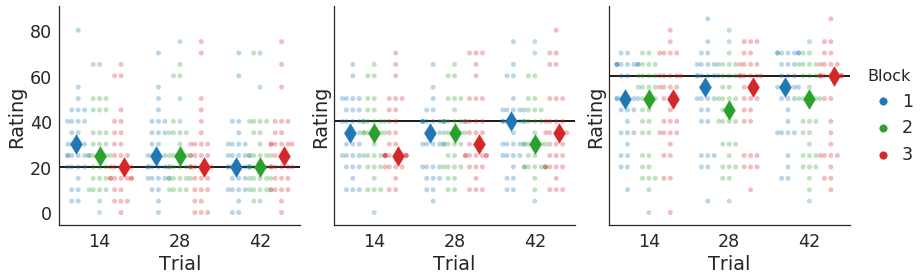

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

estimates = ratings[ratings.Variable != 'Mood'].copy()

estimates['Variable'] = np.where(estimates['Variable'].astype(int) % 3, 
                                 estimates['Variable'].astype(int) % 3, 3)

gb = estimates.groupby(['Variable','Block','Trial']).Rating.median()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4),sharex=True,sharey=True)
palette = ['#1f77b4', '#2ca02c', '#d62728']

for ax, var in zip(axes, estimates.Variable.unique()):
    
    ## Plot all points.
    sns.swarmplot('Trial', 'Rating', 'Block', estimates[estimates.Variable==var], 
                  dodge=True, palette=palette, alpha=0.3, ax=ax)
    
    ## Plot median point (weird seaborn error forcing ugly code. sorry.)
    for block, color, offset in zip([1,2,3],palette,[-0.3,0,0.3]):
        ax.scatter(np.arange(3)+offset, gb[var,block].values, s=200, marker='d', color=color, zorder=2)
        
    ## Add info.
    ax.hlines(20*var, -0.5, 2.5, zorder=1)
    if not var == 3: ax.legend_.set_visible(False)
    else: 
        ax.legend(loc=7, bbox_to_anchor=(1.3,0.5), borderpad=0, handletextpad=0.1)
        ax.legend_.set_title('Block', prop=dict(size=16))
    
sns.despine()
plt.tight_layout()

**Figure 2:** Subject estimates of reward likelihood. As might be expected based on task performance, participants on average correctly estimated the order of machine reward likelihoods: 20% > 40% > 60%. Consistent with the observation above that 20/40 errors persisted even in late learning, the average subjective estimates of the 40% probability machine were systematically less than truth. 

## Section 2: Mood Ratings
In this first section, we describe the temporal profiles of participants' self-reported mood ratings. We count the number of participants exhibiting  low variance and/or always positive/negative mood profiles (see *Demos* notebook for details).

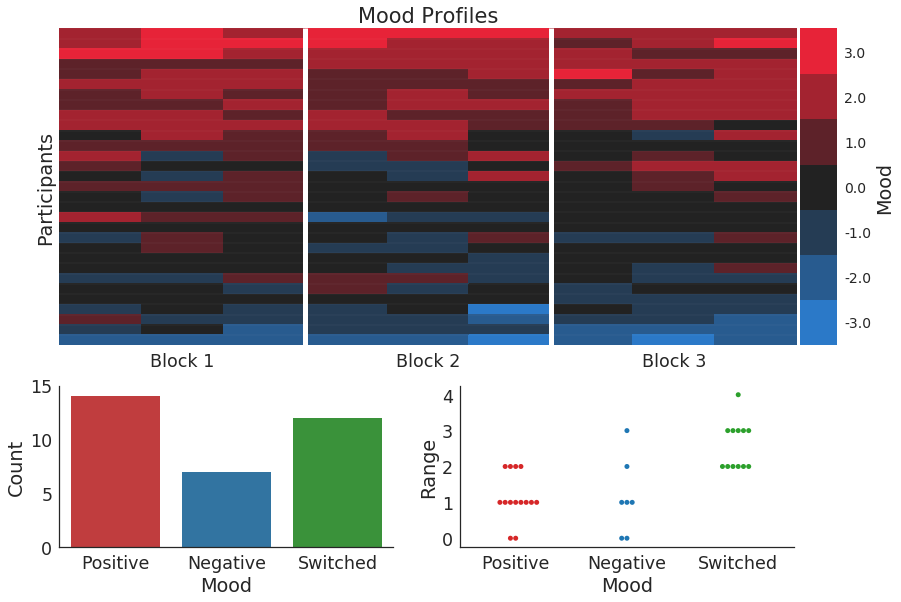

In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Subset data.
mood = ratings[ratings.Variable=='Mood'].copy()

## Define metadata.
n_subjects = mood.Datetime.unique().size
trials = np.unique( (mood.Block-1) * 42 + mood.Trial)
n_trials = trials.size

mood = mood.Rating.values.reshape(n_subjects, n_trials)

## Sort.
sort_ix = np.argsort(mood.mean(axis=-1))
mood = mood[sort_ix[::-1]]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Count.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Bin participants.
positive_only = np.all(mood >= 0, axis=-1)
negative_only = np.all(mood <= 0, axis=-1)
switched_sign = np.any(mood > 0, axis=-1) * np.any(mood < 0, axis=-1)

## Compute range.
mood_range = np.ptp(mood, axis=-1)

## Convert to DataFrame.
clusters = DataFrame(dict(Positive = positive_only, 
                          Negative = negative_only,
                          Switched = switched_sign,
                          Range = mood_range))

clusters = clusters.melt(id_vars='Range', var_name='Mood')
clusters = clusters[clusters.value]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(12,8))

## Initialize canvas and divider.
gs = gridspec.GridSpec(1,1)
gs.update(left=0.05, right=0.95, bottom=0.4, top=0.95, hspace=0, wspace=0)
ax = plt.subplot(gs[0, 0])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

## Plot.
cmap = sns.diverging_palette(250, 10, s=90, l=50, n=7, center="dark")
sns.heatmap(mood, vmin=-3, vmax=3, cmap=cmap, cbar_kws=dict(label='Mood'), ax=ax, cbar_ax=cax)

## Add info.
ax.vlines([3,6], 0, n_subjects, lw=5, color='w')
ax.hlines(np.arange(n_subjects), 0, n_trials, lw=0.05, color='w')
ax.set(xticks=[1.5,4.5,7.5], yticks=[], ylabel='Participants', title='Mood Profiles')
ax.set_xticklabels(['Block 1', 'Block 2', 'Block 3'], rotation=0)

## Update colorbar.
cbar = ax.collections[0].colorbar
cbar.set_ticks(np.linspace(-3,3,7) * 0.85)
cbar.ax.set_yticklabels(np.linspace(-3,3,7), fontsize=14)

## Initialize canvas.
gs = gridspec.GridSpec(1,2)
gs.update(left=0.05, right=0.9, bottom=0.05, top=0.33, hspace=0, wspace=0.2)

## Plot countplot.
ax = plt.subplot(gs[0, 0])
palette = ['#d62728', '#1f77b4', '#2ca02c']
sns.countplot('Mood', data=clusters, order=['Positive','Negative','Switched'],
              palette=palette, ax=ax)
ax.set(yticks=np.linspace(0,15,4), ylabel='Count')
sns.despine(ax=ax)

## Plot stripplot.
ax = plt.subplot(gs[0, 1])
sns.swarmplot('Mood', 'Range', data=clusters, order=['Positive','Negative','Switched'],
              palette=palette, ax=ax)
ax.set(yticks=np.arange(clusters.Range.max()+1), ylabel='Range')
sns.despine(ax=ax)

**Figure 3:** Mood profiles of participants. (Top) The temporal evolution of all participants' mood ratings (sorted by average mood). As can be observed, many participants remain all positive (red) or negative (blue). (Bottom left) Counts of the number of participants who remained positive ($m \geq 0$), negative ($m \leq 0$), or switched signs across all nine self-report ratings. (Bottom right) The range of participants' mood profiles. It should be noted that many participants exhibit low variability and sign constance.

### Wheel of fortune mood manipulation
We turn to the effects of the wheel of fortune (WoF) manipulation on mood.

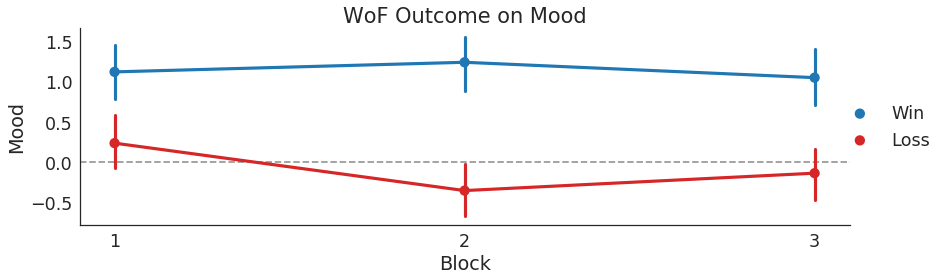

In [5]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Subset data.
mood = ratings[ratings.Variable=='Mood'].copy()

## Merge WoF info.
mood = mood.merge(metadata[['Datetime','WoF']], on='Datetime')
mood['Outcome'] = np.where(mood.WoF > 0, 'Win', 'Loss')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))
palette = ['#1f77b4', '#d62728']

## Plot.
sns.pointplot('Block', 'Rating', 'Outcome', data=mood, 
              palette=palette, ax=ax)

## Add info.
ax.hlines(0, -0.1, 2.1, linestyle='--', alpha=0.4)
ax.set(xlim=(-0.1,2.1), ylabel='Mood', title='WoF Outcome on Mood')
ax.legend(loc=7, bbox_to_anchor=(1.125,0.5))

sns.despine()
plt.tight_layout()

**Figure 4:** Wheel of Fortune (WoF) outcome affects mood. Participants who lost the WoF exhibited decreased mood afterwards.  

### Wheel of Fortune and machine preference
We reproduce the findings of the original manuscript, namely that participants who lost the Wheel of Fortune prefer slot machines with equal reward likelihood from the block prior to loss.

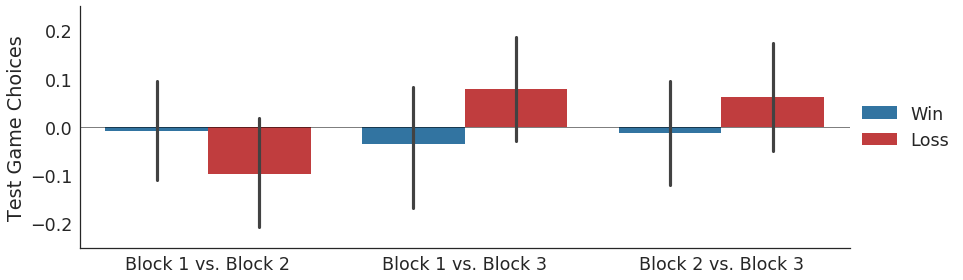

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Discrimination check.
ix = np.logical_and(data.Block==4, data.Choice.notnull())
discrimination = data[ix].copy()
discrimination = discrimination[np.equal(discrimination.M1 % 3, discrimination.M2 % 3)]
discrimination[['Choice','M1','M2']] = discrimination[['Choice','M1','M2']].apply(lambda col: np.ceil(col / 3))
discrimination['Discrimination'] = discrimination[['M1','M2']].sum(axis=1)
discrimination['Choice'] = np.equal(discrimination['Choice'], discrimination[['M1','M2']].max(axis=1))

gb = discrimination.groupby(['Datetime','Discrimination']).Choice.mean().reset_index()
gb = gb.merge(metadata[['Datetime','WoF']], on='Datetime')
gb['Outcome'] = np.where(gb.WoF > 0, 'Win', 'Loss')
gb['Choice'] -= 0.5

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))
palette = ['#1f77b4', '#d62728']

## Plot.
sns.barplot('Discrimination', 'Choice', 'Outcome', data=gb, palette=palette, ax=ax)

## Add info.
ax.hlines(0, -0.5, 2.5, lw=0.5)
ax.set(xticklabels=['Block 1 vs. Block 2', 'Block 1 vs. Block 3', 'Block 2 vs. Block 3'],  
       xlabel='', ylim=(-0.25,0.25), ylabel='Test Game Choices')
ax.legend(loc=7, bbox_to_anchor=(1.15,0.5))

sns.despine()
plt.tight_layout()

**Figure 5:** Wheel of Fortune outcome affects machine preference. In comparing machines with equal reward likelihoods, participants who lost the WoF preferred those machines from the block prior to loss.

## Section 3: Reaction Times
We next search for trends in the reaction times during learning. 

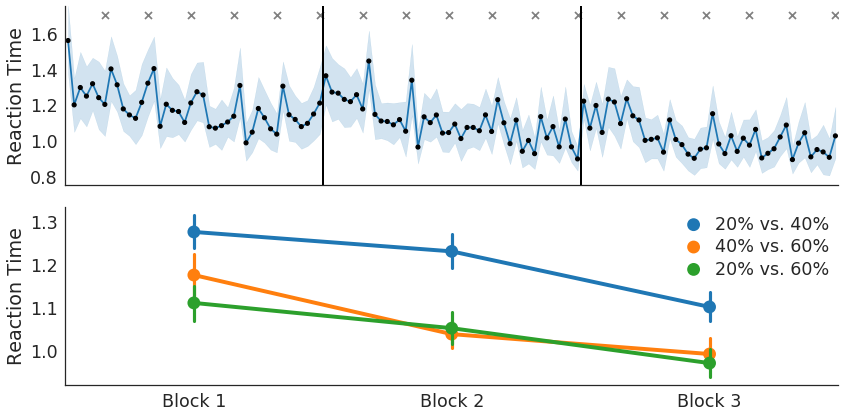

In [7]:
from pandas import Categorical

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Subset data.
rt = data[np.logical_and(data.Block < 4, data.RT.notnull())].copy()

## Span trials between 1 and 126.
rt.Trial += (rt.Block - 1) * rt.Trial.max()
rt.Trial -= 1

## Classify types of trials.
hue = np.where(rt[['M1','M2']] % 3, rt[['M1','M2']] % 3, 3).sum(axis=1)
hue = Categorical(hue, categories=[3,5,4], ordered=True).rename_categories(['20% vs. 40%', 
                                                                            '40% vs. 60%', 
                                                                            '20% vs. 60%'])
rt['TrialType'] = hue

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(2,1,figsize=(12,6))

## Plot RTs.
sns.lineplot('Trial', 'RT', data=rt, zorder=0, ax=axes[0])
sns.pointplot('Trial', 'RT', data=rt, color='k', scale=0.5, join=False, ci=None, zorder=10, ax=axes[0])

## Add info.
queries = np.concatenate([ratings.Trial.unique() + b * 42 for b in np.arange(3)])
axes[0].scatter(queries-1, np.ones_like(queries) * 1.7, marker='x', color='grey')
axes[0].vlines([41.5,83.5], 0.75, 1.75, linewidth=2)
axes[0].set(xlim=(rt.Trial.min()-0.5, rt.Trial.max()+0.5), xlabel='', xticks=[], 
            ylim=(0.75, 1.75), ylabel='Reaction Time')

## Barplot.
sns.pointplot('Block', 'RT', 'TrialType', rt, scale=1.25, ax=axes[1])
axes[1].set(xticklabels=['Block 1', 'Block 2', 'Block 3'], xlabel='', ylabel='Reaction Time')
axes[1].legend(loc=1, borderpad=0, labelspacing=0.25, handletextpad=0.25, title='')

sns.despine()
plt.tight_layout()

**Figure 6:** Reaction times reflect learning. Several important trends can be observed in the reaction times. First, reaction times decrease with learning. Second, reaction times decrease by block (perhaps reflecting increased decision confidence). Third, reaction times increased following mood/subject estimate querying (top row, gray Xs). Fourth, reaction times reflect the differences in expected value of machines: reaction times were least in the 20/60 and 40/60 conditions but higher in the 20/40 condition (perhaps reflecting the increase in subjective similarity between those two machines).